In [1]:
# Imports
import talib
import yfinance as yf
import pandas as pd
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download historical market data
ticker = "SPY"
stock = yf.Ticker(ticker)

# get historical market data
hist = stock.history(period="3y")

In [3]:
# Download historical data as dataframe
spy_data = yf.download('SPY', start='2020-01-01', end='2023-06-30')

[*********************100%***********************]  1 of 1 completed


In [4]:
spy_data.to_csv('SPY_data.csv')

In [5]:
spy_df =pd.read_csv('SPY_data.csv',index_col=0,parse_dates=True)
spy_df.dropna()

spy_df.shape

(879, 6)

In [6]:
spy_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,307.375641,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,305.048126,77709700
2020-01-06,320.489990,323.730011,320.359985,323.640015,306.211914,55653900
2020-01-07,323.019989,323.540009,322.239990,322.730011,305.350922,40496400
2020-01-08,322.940002,325.779999,322.670013,324.450012,306.978271,68296000


(array([18262., 18444., 18628., 18809., 18993., 19174., 19358., 19539.]),
 [Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01'),
  Text(19539.0, 0, '2023-07')])

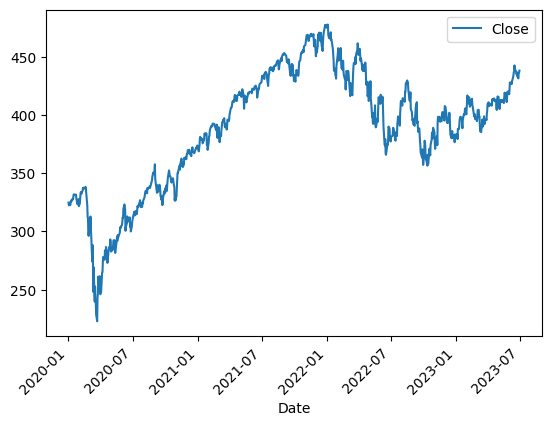

In [7]:
spy_df.plot(y='Close')
plt.xticks(rotation=45)

In [8]:
# Assuming you have a pandas DataFrame named 'df' containing your data
ema_period = 5  # EMA period
sma_period = 20  # SMA period
spy_df['EMA'] = talib.EMA(spy_df['Close'], timeperiod=ema_period)
spy_df['SMA'] = talib.SMA(spy_df['Close'], timeperiod=sma_period)

In [9]:
spy_df.dropna(how='any', inplace=True) 

In [10]:
spy_df

,Open,High,Low,Close,Adj Close,Volume,EMA,SMA
Date,,,,,,,,
2020-01-30,324.359985,327.910004,323.540009,327.679993,310.034363,75491800,327.413966,327.237003
2020-01-31,327.000000,327.170013,320.730011,321.730011,304.404816,113845600,325.519315,327.080003
2020-02-03,323.350006,326.160004,323.220001,324.119995,306.666016,69083000,325.052875,327.165503
2020-02-04,328.070007,330.010010,327.720001,329.059998,311.340057,62573200,326.388582,327.436502
2020-02-05,332.269989,333.089996,330.670013,332.859985,314.935394,65951100,328.545717,327.943001
...,...,...,...,...,...,...,...,...
2023-06-23,432.929993,435.059998,432.470001,433.209991,433.209991,92074500,435.466528,429.734499
2023-06-26,432.619995,434.609985,431.190002,431.440002,431.440002,72823600,434.124353,430.573999
2023-06-27,432.350006,436.809998,431.880005,436.170013,436.170013,72813700,434.806240,431.381500


(array([18262., 18444., 18628., 18809., 18993., 19174., 19358., 19539.]),
 [Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01'),
  Text(19539.0, 0, '2023-07')])

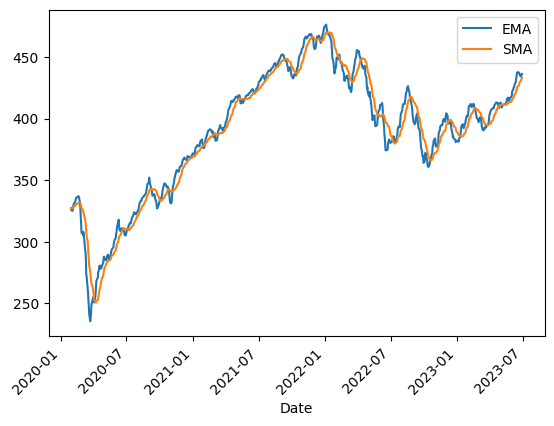

In [11]:
spy_df.plot(y=['EMA','SMA'])
plt.xticks(rotation=45)

In [12]:
spy_df['Signal'] = 0
for i in range(1, len(spy_df)):
    if spy_df['EMA'][i] > spy_df['SMA'][i] and spy_df['EMA'][i-1] <= spy_df['SMA'][i-1]:
        spy_df['Signal'][i] = 1  # EMA crosses above SMA (buy signal)
    elif spy_df['EMA'][i] < spy_df['SMA'][i] and spy_df['EMA'][i-1] >= spy_df['SMA'][i-1]:
        spy_df['Signal'][i] = -1  # EMA crosses below SMA (sell signal)


In [13]:
spy_df['Signal'].value_counts()

Signal
 0    814
-1     23
 1     23
Name: count, dtype: int64

In [14]:
# Extract the relevant columns for features and labels
X = spy_df[['SMA', 'EMA']].values[:-1]  # Features: SMA and EMA values, excluding the last row
y = spy_df['Signal'].values[1:]  # Labels: Shifted signals array without the first element


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [16]:
# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [17]:
# Make predictions on the testing set
y_pred = model.predict(X_test)

In [18]:
# Evaluate the model
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9476744186046512


In [19]:
# Use the testing data to make the model predictions
y_train_pred =  model.predict(X_train)

# Review the model's predicted values
y_train_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [20]:
y_test_pred = model.predict(X_test)

In [21]:
print(metrics.confusion_matrix(y_test, y_test_pred))

[[  0   2   0]
 [  0 163   0]
 [  0   7   0]]


In [22]:
# Use a classification report to evaluate the model using the predictions and testing data
regression_testing_report = classification_report(y_train, y_train_pred)

# Print the classification report
print(regression_testing_report)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        21
           0       0.95      1.00      0.97       650
           1       0.00      0.00      0.00        16

    accuracy                           0.95       687
   macro avg       0.32      0.33      0.32       687
weighted avg       0.90      0.95      0.92       687



In [23]:
#We will cross-check the accuracy of the model using 10-fold cross-validation.
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

[0.94186047 0.94186047 0.94186047 0.95348837 0.95348837 0.95348837
 0.94186047 0.94186047 0.94186047 0.95294118]
0.9464569083447334


In [24]:

# Generate trading signals based on the predictions
signals = []

for i in range(1, len(y_test_pred)):
    if y_test_pred[i] == 1 and y_test_pred[i-1] != 1:
        signals.append("Buy signal")
    elif y_test_pred[i] == -1 and y_test_pred[i-1] != -1:
        signals.append("Sell signal")
    else:
        signals.append("No signal")
        

In [25]:
# Print the generated trading signals
for signal in signals:
    print(signal)

No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal
No signal


In [26]:
# Interpret the predictions and generate signals
train_signals = []
test_signals = []

for prediction in y_train_pred:
    if prediction == 1:
        train_signals.append("Buy signal")
    elif prediction == -1:
        train_signals.append("Sell signal")
    else:
        train_signals.append("No signal")

In [27]:
for prediction in y_test_pred:
    if prediction == 1:
        test_signals.append("Buy signal")
    elif prediction == -1:
        test_signals.append("Sell signal")
    else:
        test_signals.append("No signal")